# 1. Marchenko-Pastur distribution

In this section we will generate $n$ random vectors of dimension $p$ according to the spiked covariance model:
$$x_i = a_iv+ \sigma\xi_i$$
### (I) MP's Distribution as applied on the Spiked Model
We will start with making some helper functions, a modified version to the example from the class.

In [190]:
# helper fuctions for the simulation
import numpy as np
import matplotlib.pyplot as plt
def marchpast(l, g,sigma):
    """Marchenko-Pastur distribution
    input: - g determines the shape of the distribution (MP) - sqrt(p/n)
           -sigma - the scale of the normal distribution
           -l - points in axis to compute the MP distribution
    return: the MP distribution for points in l"""
    def m0(a):
        "Element wise maximum of (a,0)"
        return np.maximum(a, np.zeros_like(a))
    
    gplus=(sigma*(1+g**0.5))**2
    gminus=(sigma*(1-g**0.5))**2
    return np.sqrt(  m0(gplus  - l) *  m0(l- gminus)) / ( 2*np.pi*g*l*(sigma**2))

def generate_alpa_v_vectors(n,p):
    """Generate random scalars alpha_i from the standard normal distribution"""
    v = np.random.randn(n)
    v /= np.linalg.norm(v)
    a = np.random.randn(p)
    return a,v

def cv(a):
    "Covariance matrix"
    return (np.matmul(a, a.transpose())/a.shape[1])

def randcv(n, p, sigma,a,v):
    """
    Input:
    n,p dimension of random matrix
    sigma - scale of normal distribution
    s - number of random matrices to generate
    Returns: a covariance matrix
    """
    # # Generate standard random multivariate Gaussian vectors xi
    xi = np.random.randn(n, p)
    x = (a[:, np.newaxis] * v).T + sigma * xi
    x = x-np.mean(x)
    r = cv(x)
    return r

def EE(a, gamma,sigma,to_plot=True):
    "Calculate and show histogram of eigenvalues"
    ee, ev =np.linalg.eigh(a)
    if to_plot:
      nn, bb, patches=plt.hist(ee.ravel(),bins="auto",density=True)
      x=np.arange(bb[0], bb[-1], 0.003)
      y = marchpast(x, gamma,sigma)
      return x,y,nn,ee,ev
    return ee, ev


Use the following parameters: $n = 300$; $p = 50$;$\sigma = 1$. Generate a plot with a histogram of the eigenvalues of the
covariance matrix $$R = \frac{1}{n}\sum_i{x_i x_i^T}$$. Also a line plot of Marchenko Pastur distribution is added followed by a short explanation.

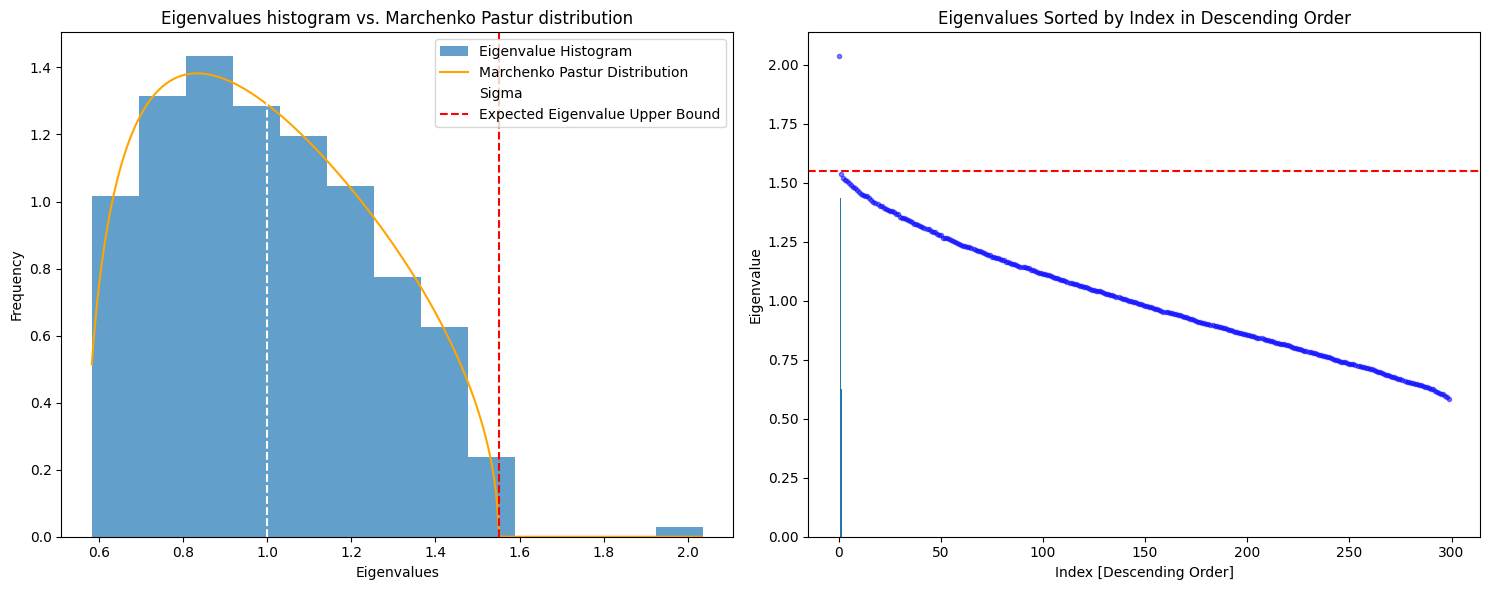

Max Eigenvalue:  2.034787473138489
Upper MP Boundary: 1.5498979485566355


In [191]:
# Set the parameters and 
p = 300
n = 5000
sigma = 1
a,v = generate_alpa_v_vectors(p,n)
r = randcv(p,n,sigma,a,v)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
x, y, nn, ee,ev = EE(r, p/n, sigma)
upper_boundary = (sigma * (1 + (p/n)**0.5))**2

axs[0].hist(ee.ravel(), bins="auto", density=True, alpha=0.7, label='Eigenvalue Histogram')
axs[0].plot(x, y, color='orange',  label='Marchenko Pastur Distribution')
axs[0].axvline(x=sigma, color='white', linestyle='--', label='Sigma')
axs[0].axvline(x=upper_boundary, color='red', linestyle='--', label='Expected Eigenvalue Upper Bound')
axs[0].set_title("Eigenvalues histogram vs. Marchenko Pastur distribution")
axs[0].set_xlabel('Eigenvalues')
axs[0].set_ylabel('Frequency')
axs[0].legend(loc='upper right')
# Scatter plot of eigenvalues against their indices on axs[1]
axs[1].scatter(np.arange(0, len(ee)), np.sort(ee)[::-1], marker='.', color='blue', alpha=0.5)
axs[1].axhline(y=upper_boundary, color='red', linestyle='--', label='Expected Eigenvalue Upper Bound')
axs[1].set_title('Eigenvalues Sorted by Index in Descending Order')
axs[1].set_xlabel('Index [Descending Order]')
axs[1].set_ylabel('Eigenvalue')

plt.tight_layout()
plt.show()
print("Max Eigenvalue: ",np.max(ee))
print("Upper MP Boundary:",upper_boundary)

Indeed the eigenvalues larger than the upper bound of the Marchenko-Pastur distribution is considered a signal (meaningful component), while the rest that lay within the bounds are considered noise.
This plot offer a visual method to distinguish between the 'signal' and 'noise' in the data, which is especially useful for dimensionality reduction and for understanding the intrinsic complexity of the dataset.

### (II) MP's Distribution and the Spiked Model 
#### with $\sigma \isin \{0.2,0.4,..,1.8,2\} $
In this section we first compute the leading eigenvector of the covariance matrix $R$ and compute the absolute value of its inner product with $v$.

In [192]:
sigma_lst = np.arange(0, 2.1, 0.2)
v_lv_ip_lst = []
for s in sigma_lst:
  a,v = generate_alpa_v_vectors(p,n)
  r = randcv(p,n,s,a,v)
  ee,ev = EE(r, p/n, s,to_plot = False)
  max_variance_index = np.argmax(ee)

  # Get the corresponding eigenvector
  leading_eigenvector = ev[:, max_variance_index]
  v_lv_ip = np.abs(np.dot(leading_eigenvector, v))
  v_lv_ip_lst.append(v_lv_ip)

Then we plot the results as a function of $\sigma$.

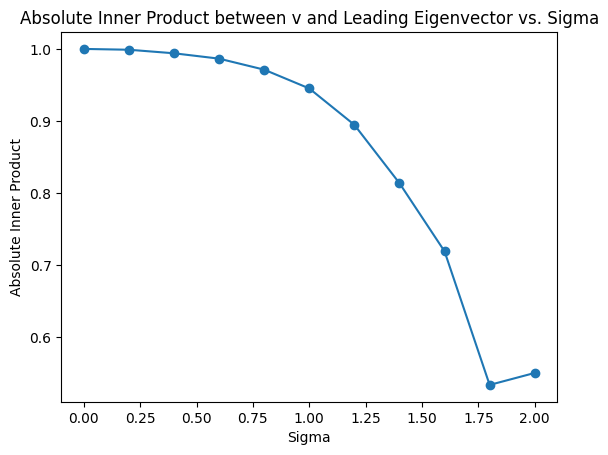

In [193]:
plt.plot(sigma_lst, v_lv_ip_lst, marker='o')
plt.title("Absolute Inner Product between v and Leading Eigenvector vs. Sigma")
plt.xlabel("Sigma")
plt.ylabel("Absolute Inner Product")
plt.show()

#### What makes the result start to degrade?
Recall that in the Spiked Covariance model, $v$ represents the eigenvector corresponding to the largest eigenvalue.

When the extracted eigenvector is the same as the real eigenvector, their inner product will return 1.
The more the subspace of our extracted eigenvector differs from the space of $v$,  their inner product of the noised eigenvector with vector will approach 0. As we know, when vectors represent different spaces they are orthogonal.
Hence, **the greatest the noise ($\sigma$) is, the bigger the harder it is to extract our objective signal.**  

# 2. Kernel Functions and Mercer's Theorem

In this section, we will prove two important properties of kernel function.

## Proof (I)
Given that:<br>
$f_{1}(x_{i},x_{j})=\langle \phi_{1}(x_{i}),\phi_{1}(x_{j})\rangle,$ <br>
$f_{2}(x_{i},x_{j})=\langle \phi_{2}(x_{i}),\phi_{2}(x_{j})\rangle$ are both valid Kernel functions.

**We will show that:**
$f_{1}(x_{i},x_{j})\cdot f_{2}(x_{i},x_{j})$  is a valid Kernel as well.


$f_{1}(x_{i},x_{j})\cdot f_{2}(x_{i},x_{j})$
$=\langle \phi_{1}(x_{i}),\phi_{1}(x_{j})\rangle \cdot\overset{scalar}{\overbrace{\langle \phi_{2}(x_{i}),\phi_{2}(x_{j})\rangle }}=\langle \phi_{1}(x_{i}),\phi_{1}(x_{j})\langle \phi_{2}(x_{i}),\phi_{2}(x_{j})\rangle \rangle =\sum_{l}\langle \phi_{2}(x_{i}),\phi_{2}(x_{j})\rangle \phi_{1}(x_{i})_{l}\phi_{1}(x_{j})_{l}$
 $=\sum_{l}[\sum_{k}\phi_{2}(x_{i})_{k}\phi_{2}(x_{j})_{k}]\phi_{1}(x_{i})_{l}\phi_{1}(x_{j})_{l}=\sum_{l}\sum_{k}\phi_{1}(x_{i})_{l}\phi_{2}(x_{i})_{k}\phi_{2}(x_{j})_{k}\phi_{1}(x_{j})_{l}=\sum_{l}\langle \phi_{1}(x_{i})_{l}\phi_{2}(x_{i}),\phi_{2}(x_{j})\phi_{1}(x_{j})_{l}\rangle$


The latest is a sum of inner products across $l$:
$\langle \phi_{1}(x_{i})_{l}\phi_{2}(x_{i}),\phi_{2}(x_{j})\phi_{1}(x_{j})_{l}\rangle $, where each $\phi_{2}$
is multiplied by scalar $\phi_{1l}$.

Each $\langle \phi_{1}(x_{i})_{l}\phi_{2}(x_{i}),\phi_{2}(x_{j})\phi_{1}(x_{j})_{l}\rangle $ **is a valid kernel**, since a valid Kernel multiplied by a scalar is a valid Kernel.
 
Hence, by the property: $f_{3}(x_{i},x_{j})=f_{1}(x_{i},x_{j})+f_{2}(x_{i},x_{j})$ the sum of valid kernels is a valid Kernel as well,
we can conclude that:<br> $ \sum_{l} \phi_{1}(x_{i})_{l}\phi_{2}(x_{i}),\phi_{2}(x_{j})\phi_{1}(x_{j})_{l}$ is a valid kernel.
$\Rightarrow f_{1}(x_{i},x_{j})\cdot f_{2}(x_{i},x_{j})$ is a valid kernel.                                      $\blacksquare$


## Proof (II)
Now, we will use the above to prove that if the polynomial kernel of first degree (which constitutes the original data) and second degree are valid
polynomials, then the polynomial kernel $f_{1}(x_{i},x_{j})=(1+x_{i}^{T}x_{j}),f_{2}(x_{i},x_{j})=(1+x_{i}^{T}x_{j})^{d}$ is a valid kernel for any degree d.<br><br>

Define:<br>
$f_{1}(x_{i},x_{j})=(1+x_{i}^{T}x_{j})$,<br>
$f_{2}(x_{i},x_{j})=(1+x_{i}^{T}x_{j})^{2}$, 
both valid Kernel functions, as we learned in class.
<br>
Therefore, $f_{3}(x_{i},x_{j})=f_{1}(x_{i},x_{j})\cdot f_{2}(x_{i},x_{j})=(1+x_{i}^{T}x_{j})^{3}$ is a valid Kernel as well by the above proven property.
 
Hence, any function in the form $(1+x_{i}^{T}x_{j})^{d}$  represents a multiplication of 
$(1+x_{i}^{T}x_{j})$ and $(1+x_{i}^{T}x_{j})^{2}$ **and thus constituting a valid kernel.** $\blacksquare$


In particular,we can denote: $d=\sum_{i}1+\sum_{j}2$
<br>and achieve:<br>
$f_{d}=(1+x_{i}^{T}x_{j})^{d}=(1+x_{i}^{T}x_{j})^{\sum_{i}1+\sum_{j}2}=(1+x_{i}^{T}x_{j})^{\sum_{i}1}\cdot(1+x_{i}^{T}x_{j})^{\sum_{j}2}$

$ =(1+x_{i}^{T}x_{j})\cdot(1+x_{i}^{T}x_{j})\cdots(1+x_{i}^{T}x_{j})\cdot(1+x_{i}^{T}x_{j})^{2}\cdot(1+x_{i}^{T}x_{j})^{2}\cdots(1+x_{i}^{T}x_{j})^{2}$
 
It's evident that  $f_{d}$  is a multiplication of valid kernels, thereby confirming its validity as a kernel.

**We can generally establish this through *induction* as well:**

For $d=1,2$ we have:<br>
$f_{1}(x_{i},x_{j})=(1+x_{i}^{T}x_{j}),f_{1}(x_{i},x_{j})=(1+x_{i}^{T}x_{j})^{2}$, 
both of which are valid kernel functions.
<br>
We have previously proven this for $d=3$.<br>

Assume it holds for $d=n-1$, meaning: 
$f_{n-1}(x_{i},x_{j})=(1+x_{i}^{T}x_{j})^{n-1} \ $   is a valid Kernel. 
Then we can prove it for $d=n$ or $d=n+1$<br>

From the induction assumption, $f_{n-1}$ is a valid kernel, and it's given that $f_{1}$ is also a valid kernel.
Multiplying two valid kernels yields a valid kernel, following Proof (I):<br>
$f_{n}(x_{i},x_{j})=f_{n-1}\cdot f_{1}=(1+x_{i}^{T}x_{j})^{n-1}\cdot(1+x_{i}^{T}x_{j})=(1+x_{i}^{T}x_{j})^{n}=(1+x_{i}^{T}x_{j})^{d}$ ; is a valid kernel function. <br>

It is appropriate to extend this proof to $d=n+1$ since it involves multiplying $f_{n-1}$ with $f_{2}$, which are both valid kernel functions.

Therefore, the same reasoning applies, confirming the validity of the kernel for every $d=n+1.$ $\blacksquare$

# 3 Kernel PCA to Non-Linearly Distributed Data

In this section we will find a parameter setting for which kernel PCA successfully separates 
the datasets of two moons and circles into two clusters. We will also show a parameter setting for which it does not and try to explain why it fails.

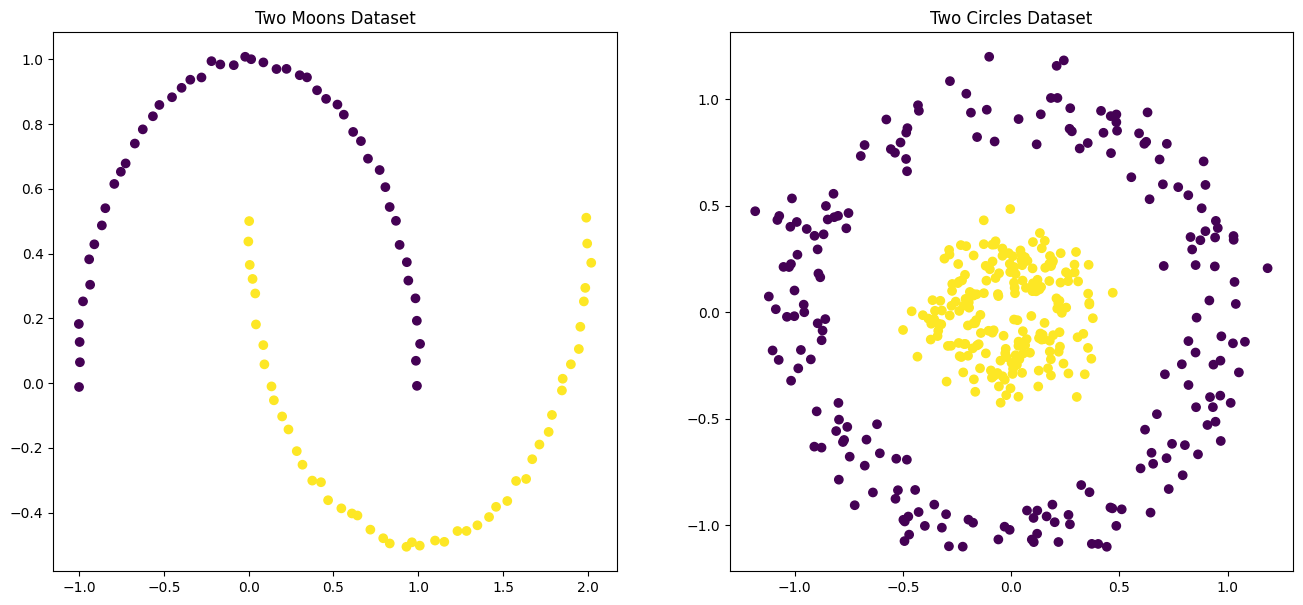

In [194]:
from sklearn.datasets import make_moons, make_circles
# Generate the two moons dataset
X_moons, y_moons = make_moons(n_samples=100,noise=0.01 ,random_state=42)

# Generate two circles dataset
def generate_circle_data(radius, center, n_samples=200, noise=0.1):
    """
    Generate n_samples points along a circle with specified radius and center.
    Gaussian noise is added to the points.
    """
    angles = np.random.rand(n_samples) * 2 * np.pi
    x = center[0] + radius * np.cos(angles)
    y = center[1] + radius * np.sin(angles)
    noise = np.random.normal(scale=noise ,size=(n_samples, 2))
    return np.column_stack([x, y]) + noise

X_circle_large = generate_circle_data(radius=1, center=(0, 0))
X_circle_small = generate_circle_data(radius=0.25, center=(0, 0))
X_circles = np.vstack([X_circle_large, X_circle_small])
y_circles = np.array([0]*200 + [1]*200)  # Labels: 0 for large circle, 1 for small circle

# X_circles ,y_circles= make_circles(200, noise=0.1, factor=0.25, random_state=42)

"""Plotting the datasets"""
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.title("Two Moons Dataset")
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)
plt.subplot(1, 2, 2)
plt.title("Two Circles Dataset")
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles)
plt.show()

#### PCA with Gaussian kernel function 
We will apply the Gaussian kernel function, a.k.a RBF (Radial Basis Function) kernel:

$$k(x_i, x_j) = \exp\left(- \frac{||x_i, x_j||^2}{2\sigma^2} \right) = \exp\left(- \gamma ||x_i, x_j||^2\right)$$
Where we can denote $\gamma = \frac{1}{2\sigma^2}$ as our scaling parameter.

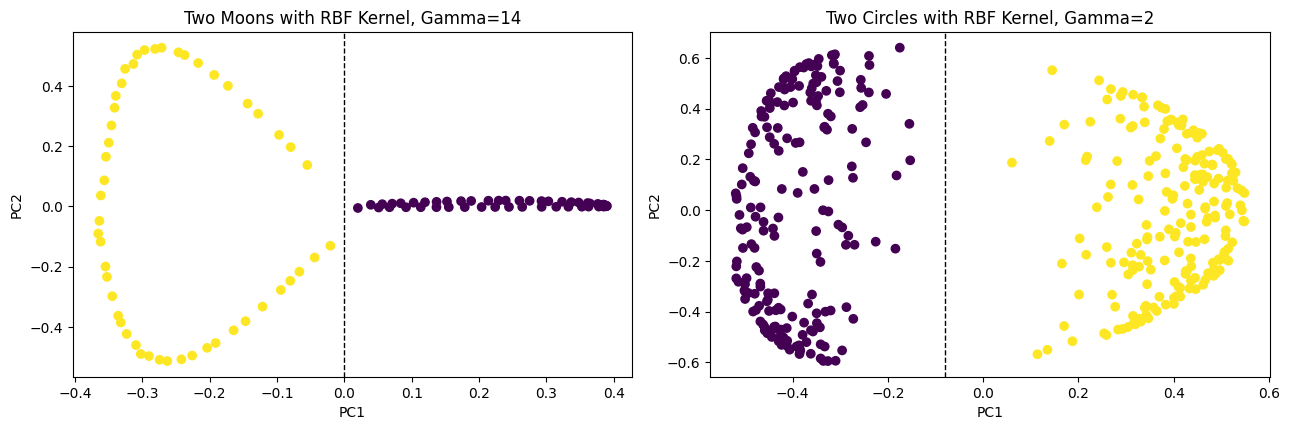

In [197]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA

# A General Function to apply Kernel PCA and plot the results
def apply_and_plot_kernel_pca(X, y, kernel, title):
    X_kpca = kernel.fit_transform(X)
    plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=y)
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')

# Applying Kernel PCA with different parameters
plt.figure(figsize=(13, 8))

# Two Moons with RBF kernel (should separate well)
plt.subplot(2, 2, 1)
gamma = 14
kernel = KernelPCA(kernel='rbf', gamma=gamma, n_components=2)
apply_and_plot_kernel_pca(X_moons, y_moons, kernel=kernel, title=f"Two Moons with RBF Kernel, Gamma={gamma}")
plt.axvline(x=0.0, linestyle='dashed', color='black', linewidth=1)

# Two Circles with RBF kernel (should separate well)
plt.subplot(2, 2, 2)
gamma = 2
kernel = KernelPCA(kernel='rbf', gamma=gamma, n_components=2)

apply_and_plot_kernel_pca(X_circles, y_circles, kernel=kernel, title=f"Two Circles with RBF Kernel, Gamma={gamma}")
plt.axvline(x=-0.08, linestyle='dashed', color='black', linewidth=1)


plt.tight_layout()
plt.show()

After some iterations attempting different Gamma values we managed to reveal a sufficient separation. Now, we will see examples of parameter settings that did not achieve a separation.


#### PCA with the polynomial function:

Polynomial kernels in machine learning, particularly in support vector machines (SVMs), are a type of kernel function that represents the similarity of vectors (samples) in a feature space over polynomials of the original variables. The polynomial kernel looks like this:
$$k(x_i, x_j)=(c+x_{i}^{T}x_{j})^{d}$$

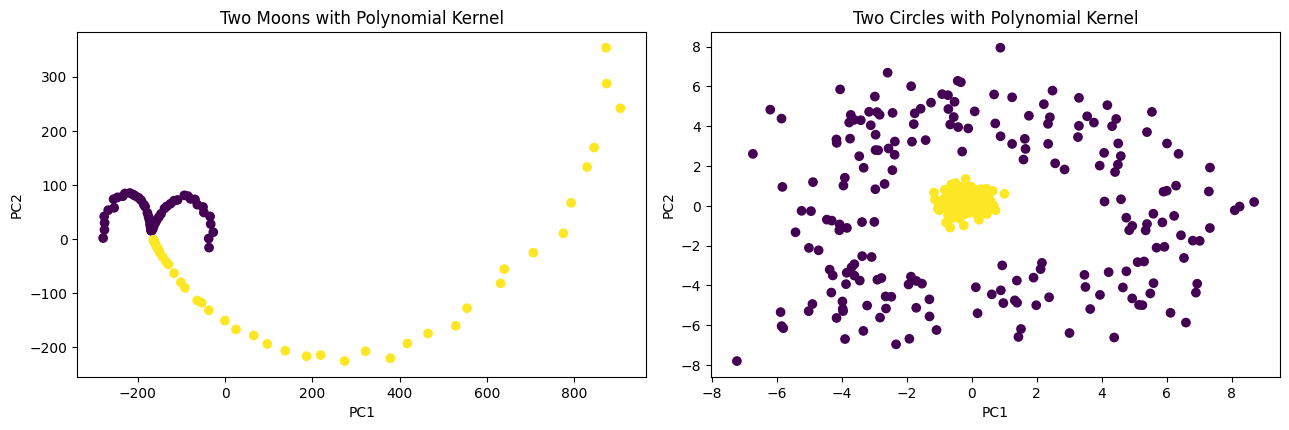

In [198]:
# Applying Kernel PCA with different parameters
plt.figure(figsize=(13, 8))

# Two Moons with RBF kernel (should separate well)
plt.subplot(2, 2, 1)

kernel = KernelPCA(kernel='poly',degree=3, gamma=25, n_components=2)
apply_and_plot_kernel_pca(X_moons, y_moons, kernel=kernel, title="Two Moons with Polynomial Kernel")
# plt.axvline(x=0.0, linestyle='dashed', color='black', linewidth=1)

# Two Circles with RBF kernel (should separate well)
plt.subplot(2, 2, 2)
kernel = KernelPCA(kernel='poly', gamma=3,degree=3, n_components=2)

apply_and_plot_kernel_pca(X_circles, y_circles, kernel=kernel, title="Two Circles with Polynomial Kernel")
# plt.axvline(x=-0.08, linestyle='dashed', color='black', linewidth=1)


plt.tight_layout()
plt.show()

#### Why that dose not work?
The polynomial kernel maps the input space to a higher-dimensional space using a polynomial of a fixed degree. However, the complexity required to separate the Moons or Circle datasets might not match the fixed degree of the polynomial. In other words, a low-degree polynomial might not capture the complex boundary, and a high-degree polynomial is expensive to find and compute. 